In [1]:
import math
import numpy as np

# package to read and write geospatial raster data
import rasterio

# for reprojection
import rasterio.crs
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.mask import mask

from matplotlib import pyplot as plt

import warnings
import geopandas as gpd
warnings.filterwarnings('ignore')

In [2]:
ds = rasterio.open('../data/Vic_Rainfall/Victoria rainfall grid.asc', 'r')

In [3]:

dest_crs = rasterio.crs.CRS.from_epsg(7855)

# output resolution (1km by 1km cell size for the new, transformed BoM raster - we are
# starting off with what is already a very low-resolution raster, so it does not make
# sense to use a finer resolution here)
out_res = (1000, 1000)

# calculating transform array and shape of reprojected raster
out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(ds.crs,
                                                                                 dest_crs,
                                                                                 ds.width,
                                                                                 ds.height, 
                                                                                 resolution = out_res,
                                                                                 *ds.bounds)

out_profile = ds.profile

# updating destination raster metadata
out_profile['height'] = out_height
out_profile['width'] = out_width
out_profile['crs'] = dest_crs
out_profile['transform'] = out_transform

# defining output path and filename
out_raster_file = '../data/Vic_Rainfall/vic_rainfall_grid_epsg7855.tif'

# while exporting the raster we need to change the mode to 'w' and provide raster 'profile' parameters
# we also specify that the TIFF file should be compressed using the DEFLATE algorithm
with rasterio.open(out_raster_file, 'w', **out_profile, compress='DEFLATE') as ds_out:
    rasterio.warp.reproject(source = rasterio.band(ds, 1),
                            destination = rasterio.band(ds_out, 1),
                            src_crs = ds.crs,
                            dst_crs = ds_out.crs,
                            dst_resolution = out_res,
                            # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
                            resampling = Resampling.bilinear)

In [4]:
ds.close()

In [5]:
ds = rasterio.open('../data/Vic_Rainfall/vic_rainfall_grid_epsg7855.tif', 'r')

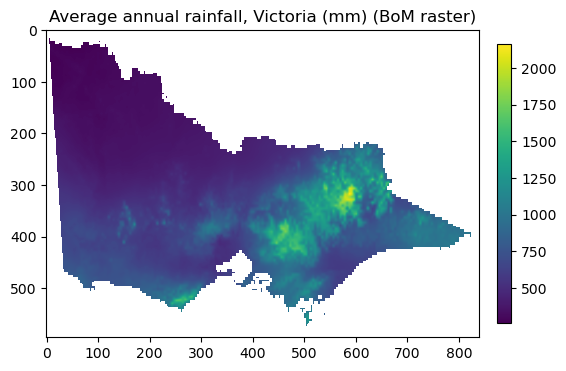

In [6]:
plt.figure(figsize = (6, 6))
band1 = ds.read(1)
band1[band1 == ds.nodata] = np.NaN
im = plt.imshow(band1, cmap = 'viridis')
plt.colorbar(im, fraction = 0.03, pad = 0.04)

plt.title('Average annual rainfall, Victoria (mm) (BoM raster)')

plt.show()

In [7]:
GCCSA = gpd.read_file('../data/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp')
GCCSA = GCCSA.to_crs("EPSG:7855")
GreaterMelb = GCCSA[GCCSA['GCC_NAME21'] == 'Greater Melbourne']

In [8]:
geometries = GreaterMelb.geometry.values
out_image, out_transform = mask(ds, geometries, crop=True)

# Update the metadata
out_meta = ds.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the cropped raster to a new file
with rasterio.open('../data/Vic_Rainfall/Greater_Melbourne_rainfall_grid_epsg7855.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

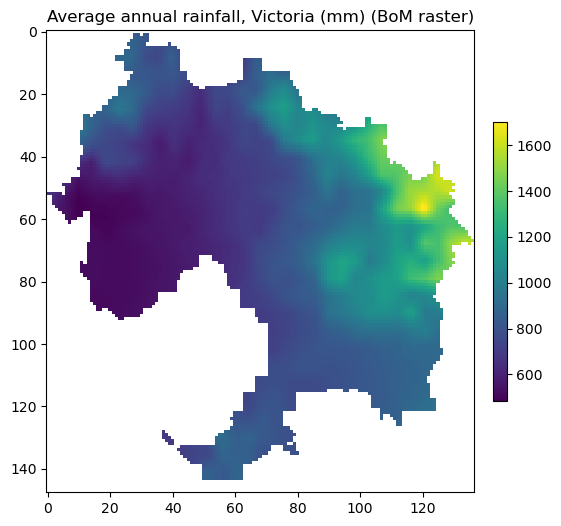

In [9]:
ds = rasterio.open('../data/Vic_Rainfall/Greater_Melbourne_rainfall_grid_epsg7855.tif', 'r')
plt.figure(figsize = (6, 6))
band1 = ds.read(1)
band1[band1 == ds.nodata] = np.NaN
im = plt.imshow(band1, cmap = 'viridis')
plt.colorbar(im, fraction = 0.03, pad = 0.04)

plt.title('Average annual rainfall, Victoria (mm) (BoM raster)')

plt.show()

In [10]:
boundary = gpd.read_file('../data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp')
boundary = boundary[boundary['GCC_NAME21'] == 'Greater Melbourne']
boundary['geometry'] = boundary['geometry'].to_crs('EPSG:7855')

In [11]:
from rasterstats import zonal_stats


In [15]:
# Calculate zonal statistics
stats = zonal_stats(boundary, band1, stats='mean', affine=ds.transform)
# Add the mean values to the GeoDataFrame
boundary['mean_rainfall_value'] = [stat['mean'] for stat in stats]

In [19]:
boundary[['SA2_NAME21', 'geometry', 'mean_rainfall_value']]

,SA2_NAME21,geometry,mean_rainfall_value
755,Brunswick East,"POLYGON ((321462.804 5818449.962, 321487.503 5...",651.929850
756,Brunswick West,"POLYGON ((318017.323 5818838.780, 318015.308 5...",634.387207
757,Pascoe Vale South,"POLYGON ((317848.490 5820770.142, 317836.510 5...",636.294250
758,Brunswick - North,"POLYGON ((319443.585 5819047.655, 319453.568 5...",646.838298
759,Brunswick - South,"POLYGON ((319433.185 5817708.481, 319382.905 5...",639.805420
...,...,...,...
1111,Point Nepean,"MULTIPOLYGON (((306785.954 5748196.009, 306782...",723.777965
1112,Rosebud - McCrae,"POLYGON ((313992.116 5751703.648, 314057.719 5...",837.861478
1113,Somerville,"POLYGON ((333076.946 5766844.520, 333622.838 5...",785.125219
1114,Mornington - East,"POLYGON ((329061.111 5767122.497, 329084.589 5...",760.163295


In [22]:
sum(boundary['mean_rainfall_value'].isna())

4